# DAMIC100 Efficiency notebook

This notebook sums up the study about the efficiency calculation. It includes the processing steps and the cuts made to compute the efficiency. 


## processing

I did the processing on my computer. The way it is done in term of script make it complicated to do in Lyon.  
- PointDepSim: The version I use is now on the svn. It is also on my github. It draws energy deposition uniformly in x,y,z and either with an exponential or uniform dependance in energy (we use exponential at low energy and uniform at higher ones.)
- blanks every run ending with 1 (83x7 blanks)
- we produce a set of 83 clusters files for each extension and each pds file has 100 clusters.
    -  PointDepSim("../clusters/ext6/c",83,100,0.03,1,4,0.0675,0.0015,0.150,4116,43)

- the read_many script is splitted is different parts so that we can apply a different config file for each extension:
    -   bash read_many_mine1.sh ../clusters/ext11/ ../after_recon/ ../log/ 1 ext11.cfg ../../blanks/
    -   bash read_many_mine2.sh ../clusters/ext6/ ../after_recon/ ../log/ 1 default.cfg ../../blanks/
    -   bash read_many_mine3.sh ../clusters/ext6/ ../after_recon/ ../log/ 1 default.cfg ../../blanks/

- Then still in the recon folder:  
    - bash process_many_mine.sh ../after_recon ../../supermask/ ../log/ default.cfg  
    
- And finally in the pointFitScan:  
    - bash process_many.sh ../after_recon ../after_pfs ../log 2.6e-4 1


- I did several runs:
    - run1: E in [0.03 - 0.8] 
    - run2: E in [0.03 - 0.8]
    - run3: E in [0.03 - 0.8]
and blanks can be found at:
    





## analysis

In [120]:
# import part
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import curve_fit

### import of the data:

The data were processed in several runs, we import them one by one and combine them

In [121]:
dfrun1rec = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run1/pkl/run1.pkl')
dfrun1sim = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run1/pkl/run1_sim.pkl')

dfrun2rec = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run2/pkl/run2.pkl')
dfrun2sim = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run2/pkl/run2_sim.pkl')

dfrun3rec = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run3/pkl/run3.pkl')
dfrun3sim = pd.read_pickle('/Users/gaior/DAMIC/code/efficiency/20200515/run3/pkl/run3_sim.pkl')


In [122]:
# merge the files:
dfall = pd.concat([dfrun1rec, dfrun2rec, dfrun3rec])
dfallsim = pd.concat([dfrun1sim, dfrun2sim, dfrun3sim])

In [123]:
dfall.columns

Index(['RUNID', 'EXTID', 'EXPSTART', 'EXPTIME', 'efact', 'nvalidpix', 'cid',
       'centerx', 'centery', 'linlength', 'is_masked', 'sadc', 'qguess',
       'sguess', 'oguessg', 'oguessc', 'llg', 'llc', 'success', 'status', 'll',
       'll_enlarg', 'llc_enlarg', 'll_14', 'llc_14', 'meanx', 'meanx_err',
       'sigma', 'sigma_err', 'efit', 'qbase', 'qbase_err', 'npix', 'npix1p6',
       'npix2', 'npix2p5', 'npix4', 'gmeanx', 'gmeanx_err', 'gsigma',
       'gsigma_err', 'gbase', 'gbase_err', 'gnorm', 'gnorm_err', 'gene',
       'gchi2', 'gll', 'cbase', 'cbase_err', 'cchi2', 'cll', 'ene1',
       'ene_integ', 'prob', 'chi2g', 'chi2c', 'qmax', 'qdelta_dx', 'qdelta_sx',
       'touchmask', 'is_premasked', 'sime', 'simz', 'simx', 'simy', 'simn',
       'simdistx', 'simdisty', 'multirows', 'dll'],
      dtype='object')

In [124]:
# function definition of the efficiency calculation:
def geteff(dfrec, dfsim, bins, cutrec, cutsim):    
    dfsel = dfrec.query(cutrec)   
    dfsel_ri = dfsel.reset_index()
    dfsel_ri['ebinned'] = pd.cut(dfsel_ri['ene1'],bins)
    ebinned = dfsel_ri.groupby('ebinned') 
    dfselsim = dfsim.query(cutsim)
    dfselsim_ri = dfselsim.reset_index()

    dfselsim_ri['ebinned'] = pd.cut(dfselsim_ri['sime'],bins)
    ebinnedsim = dfselsim_ri.groupby('ebinned')

    recnr = ebinned.size().values
    simnr = ebinnedsim.size().values
    eff = recnr/simnr
    err_eff = eff_errors(recnr, simnr, 'poisson')
    cbins = (bins[1:] + bins[:-1]) /2
    return [cbins,eff,err_eff]


def geteffsim(dfrec, dfsim, bins, cutrec, cutsim):    
    dfsel = dfrec
    dfselsim = dfsim
    dfsel = dfrec.query(cutrec + "& sime >0")
    dfsel = dfsel.reset_index()
    dfsel['ebinned'] = pd.cut(dfsel['sime'],bins)
    ebinned = dfsel.groupby('ebinned') 
    dfselsim = dfsim.query(cutsim)
    dfselsim = dfselsim.reset_index()

    dfselsim['ebinned'] = pd.cut(dfselsim['sime'],bins)
    ebinnedsim = dfselsim.groupby('ebinned')

    recnr = ebinned.size().values
    simnr = ebinnedsim.size().values
    
    
    eff = recnr/simnr
    #print (eff)
    err_eff = eff_errors(recnr, simnr, 'poisson')
    cbins = (bins[1:] + bins[:-1]) /2
    return [cbins,eff,err_eff]



def eff_errors(k, N, method):
    k = k.astype(float)
    N = N.astype(float)
    if method == 'binomial':
        return (1/N)*np.sqrt(k*(1-(k/N) ))
    if method == 'poisson':
        return np.sqrt( (k*(N+k))/N**3 )
    if method == 'bayes':
	    return np.sqrt( ((k+1)*(k+2)) / ((N+2)*(N+3)) - (k+1)**2/(N+2)**2 )


def eff_function(x,a,b,c,d,e,f,g):
    eff = (1./(1+np.exp(-(x-a)*b))  - c ) *((d*x +e)+(f*np.exp(-g*x)))
    return eff
oldparam = [7.33799254e-02, 7.44618389e+01, 4.72489658e-02, -1.11708055e-03,9.28825553e-01,  4.59657114e-02,  2.15910338e+00]

def eff_functionfit(x, eff, error=None):
    # parameters in Javier's code for signal eff 1x100                                                                                      
    a=0.159514
    b=20.2396
    c=0.0752355
    d=0.00467332
    e=0.503398
    f=0.157751
    g= 1.05736
    aa = 8.27531595e-02
    bb = 7.47224752e+01
    cc = 2.75889754e-02
    dd =  -2.74252052e-03
    ee = 9.20813172e-01
    ff = 3.24463575e-02
    gg = 2.23398725
#    init_guess = [a,b,c,d,e,f,g]                                                                                                           
    init_guess = [aa,bb,cc,dd,ee,ff,gg]
#    if error!=None:                                                                                                                        
    popt, pcov = curve_fit(eff_function, x, eff,sigma=error,p0=init_guess)
    return [popt,pcov]


In [125]:
radoncut = " (RUNID<2564 | RUNID>2566) &  (RUNID< 2902 | RUNID> 2903) & (RUNID<3267 | RUNID>3336) & (RUNID<3353 | RUNID>3419) & (RUNID<3654 \
| RUNID> 3657) & (RUNID<3764 | RUNID>3767) & (RUNID<3826 | RUNID>3853) & (RUNID<3868 | RUNID>3874) & (RUNID<3913 | RUNID>3921) & (RUNID<4003\
 | RUNID > 4007) & (RUNID<4207 | RUNID > 4212)"

badimage = 'RUNID!=2473 & RUNID!=2479 & RUNID!=2482 & RUNID!=2559 & RUNID!=2577 & RUNID!=2611 & RUNID!=2623  & RUNID!=2829 & RUNID!=2843 & R\
UNID!=2849 & RUNID!=2853 &  RUNID!=2902 & RUNID!=2927 & RUNID !=3003 & RUNID!=3011 & RUNID!=3018 & RUNID!=3020 & RUNID!=3059 & RUNID!=3112 &\
 RUNID!=3203 & RUNID!=3250 & RUNID!=3332 & RUNID!=3345 & RUNID!=3417 & RUNID!=3453 & RUNID!=3473 & RUNID!=3483 & RUNID!=3536 & RUNID!=3545 &\
 RUNID!=3584 & RUNID!=3634 & RUNID!=3636 & RUNID!=3637 & RUNID!=3638 & RUNID!=3639 & RUNID!=3654 & RUNID!=3655 & RUNID!=3656 & RUNID!=3685  \
& RUNID!=3698 & RUNID!=3707 & RUNID!=3751 & RUNID!=3807 & RUNID!=3852 & RUNID!=3905 & RUNID!=3931 & RUNID!=3958 & RUNID!=4011 & RUNID!=4044 \
& RUNID!=4074 & RUNID!=4083 & RUNID!=4127'


negativepixelimage = '(RUNID!=3024 | EXTID!=11) &(RUNID!=3029 | EXTID!=11) & (RUNID!=3029 | EXTID!=12)  & (RUNID!=3125 | EXTID!=11) & (RUNID\
!=3125 | EXTID!=12) &(RUNID!=3126 | EXTID!=11) & (RUNID!=3126 | EXTID!=12) & (RUNID!=3537 | EXTID!=2) & (RUNID!=3537 | EXTID!=12)  & (RUNID!\
=3538 | EXTID!=2) & (RUNID!=3538 | EXTID!=12)  & (RUNID!=3539 | EXTID!=2) & (RUNID!=3539 | EXTID!=12)  & (RUNID!=3540 | EXTID!=2) &(RUNID!=3\
540 | EXTID!=12) &(RUNID!=3541 | EXTID!=2) & (RUNID!=3541 | EXTID!=12) &  (RUNID!=3542 | EXTID!=2) & (RUNID!=3542 | EXTID!=12) & (RUNID!=354\
3 | EXTID!=2) & (RUNID!=3543 | EXTID!=12) & (RUNID!=3544 | EXTID!=2) & (RUNID!=3546 | EXTID!=12) & (RUNID!=3548 | EXTID!=12) & (RUNID!=3598 \
| EXTID!=12) &(RUNID!=3657 | EXTID!=4) & (RUNID!=3657| EXTID!=6) & (RUNID!=3657 | EXTID!=11) & (RUNID!=3657 | EXTID!=12)'


In [126]:
dfall = dfall.query(negativepixelimage)
dfallsim = dfallsim.query(negativepixelimage)
dfall = dfall.query(radoncut)
dfallsim = dfallsim.query(radoncut)
dfall = dfall.query(badimage)
dfallsim = dfallsim.query(badimage)


In [127]:
recpositioncut = 'centery < 42 & centery > 1 & (centerx < 8250 & centerx > 4400) & (simdistx == 0 | (simdistx > 5) & (simdisty > 2) )'
simpositioncut = 'simy < 42 & simy > 1 & (simx < 8250 & simx > 4400) & ((simdistx > 5) & (simdisty > 2) )'
maskcut = 'is_masked == 0 & touchmask == 0 & success ==1'
llcut = 'll_14 < 90'
qmaxcut = 'qmax/(ene1*1000./3.77) > 0.2'
basecuts = maskcut + ' & ' +  llcut+ ' & ' +  qmaxcut

after no cut:  0.9961145217748685
after llcut:  0.9904610477191448
after llcut + qmaxcut:  0.989494937935599
after llcut + qmaxcut + maskcut:  0.9249910741361754
after llcut + qmaxcut + maskcut + multirows:  0.9012942145857564


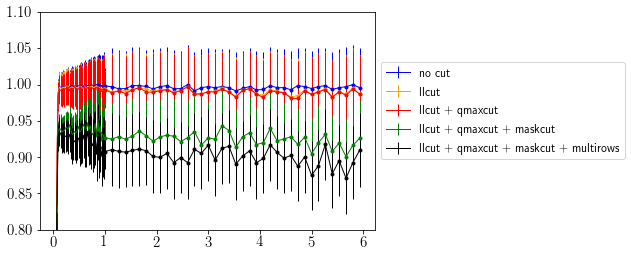

In [142]:
bins = np.linspace(0.03,1,40)
bins2 = np.linspace(0.8,6,40)

# here we consider a CCD cut on the sides.
dfall = dfall.query(recpositioncut)
dfallsim = dfallsim.query(simpositioncut)

dfrecstep = dfall.copy()
dfsimstep = dfallsim.copy()

[cbins, eff_r, err_eff_r] = geteffsim(dfrecstep,dfsimstep,bins,"RUNID!=0","RUNID!=0")
[cbins2, eff_r2, err_eff_r2] = geteffsim(dfrecstep,dfsimstep,bins2,"RUNID!=0","RUNID!=0")
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='blue',label='no cut')
plt.errorbar(cbins2,eff_r2, yerr=err_eff_r2,fmt='.-',color='blue')
print('after no cut: ', np.mean(eff_r2))

[cbins, eff_r, err_eff_r] = geteffsim(dfrecstep,dfsimstep,bins,llcut,"RUNID!=0")
[cbins2, eff_r2, err_eff_r2] = geteffsim(dfrecstep,dfsimstep,bins2,llcut,"RUNID!=0")
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='orange',label='llcut')
plt.errorbar(cbins2,eff_r2, yerr=err_eff_r2,fmt='.-',color='orange')
print('after llcut: ', np.mean(eff_r2))

[cbins, eff_r, err_eff_r] = geteffsim(dfrecstep,dfsimstep,bins,llcut  + ' & '+  qmaxcut,"RUNID!=0")
[cbins2, eff_r2, err_eff_r2] = geteffsim(dfrecstep,dfsimstep,bins2,llcut  + ' & ' + qmaxcut,"RUNID!=0")
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='red',label='llcut + qmaxcut')
plt.errorbar(cbins2,eff_r2, yerr=err_eff_r2,fmt='.-',color='red')
print('after llcut + qmaxcut: ', np.mean(eff_r2))

[cbins, eff_r, err_eff_r] = geteffsim(dfrecstep,dfsimstep,bins,llcut  + ' & '+  qmaxcut+ ' & '+  maskcut,"RUNID!=0")
[cbins2, eff_r2, err_eff_r2] = geteffsim(dfrecstep,dfsimstep,bins2,llcut  + ' & ' + qmaxcut+ ' & '+  maskcut,"RUNID!=0")
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='green',label='llcut + qmaxcut + maskcut')
plt.errorbar(cbins2,eff_r2, yerr=err_eff_r2,fmt='.-',color='green')
print('after llcut + qmaxcut + maskcut: ', np.mean(eff_r2))

[cbins, eff_r, err_eff_r] = geteffsim(dfrecstep,dfsimstep,bins,llcut  + ' & '+  qmaxcut+ ' & '+  maskcut +' & multirows == 0',"RUNID!=0")
[cbins2, eff_r2, err_eff_r2] = geteffsim(dfrecstep,dfsimstep,bins2,llcut  + ' & ' + qmaxcut+ ' & '+  maskcut + ' & multirows == 0',"RUNID!=0")
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='black',label='llcut + qmaxcut + maskcut + multirows')
plt.errorbar(cbins2,eff_r2, yerr=err_eff_r2,fmt='.-',color='black')
print('after llcut + qmaxcut + maskcut + multirows: ', np.mean(eff_r2))

plt.ylim(0.8,1.1)
#plt.xlim(0.3,1.1)
plt.legend( bbox_to_anchor=(1, 0.8))

In [129]:
dfallsel = dfall.query(basecuts)
dfallsel = dfallsel.query(recpositioncut + ' & multirows == 0')
dfallsimsel = dfallsim.query(simpositioncut)

(0.3, 0.95)

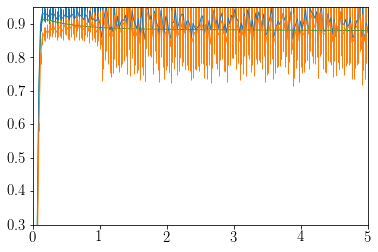

In [143]:
bins = np.linspace(0.03,6,250)
dfrec = dfallsel.copy()
dfsim = dfallsimsel.copy()

[cbins, eff_r, err_eff_r] = geteffsim(dfrec,dfsim,bins,"dll< -22","RUNID!=0")
[cbins, eff_r2, err_eff_r2] = geteffsim(dfrec,dfsim,bins,"dll< -22  & npix1p6 >1","RUNID!=0")

plt.errorbar(cbins,eff_r, yerr=err_eff_r,label='22')
plt.errorbar(cbins,eff_r2, yerr=err_eff_r2,label='22')

plt.plot(cbins,eff_function(cbins,*oldparam))
plt.xlim(0,5)
plt.ylim(0.3,0.95)

In [144]:
[popt, pcov] = eff_functionfit(cbins, eff_r, err_eff_r)
[popt2, pcov2] = eff_functionfit(cbins, eff_r2, err_eff_r2)

[ 7.35104167e-02  7.78617615e+01  5.16026193e-02 -3.81378386e-03
  9.61927446e-01  2.67301413e-02  1.55786840e+00]
[ 7.86963075e-02  8.32101320e+01  3.28498386e-02 -2.30637950e-03
  9.21328765e-01 -1.63286169e-01  1.14679011e+01]


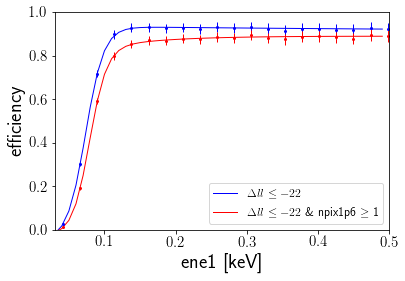

In [146]:
print (popt)
print (popt2)
bins = np.arange(0.03,0.5,0.01)
#print (np.sqrt(np.diag(pcov)))
plt.errorbar(cbins,eff_r, yerr=err_eff_r,color='blue',fmt='o',markersize=2)
plt.plot(bins,eff_function(bins,*popt),color='blue',label=r'$\Delta ll \leq -22$')
plt.errorbar(cbins,eff_r2, yerr=err_eff_r2,color='red',fmt='o',markersize=2)
plt.plot(bins,eff_function(bins,*popt2),color='red',label=r'$\Delta ll \leq -22$ \& npix1p6 $\geq$ 1' )
plt.xlim(0.03,0.5)
plt.ylim(0,1)
plt.xlabel('ene1 [keV]')
plt.ylabel('efficiency')
plt.legend()


### splitting the components: